In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys

sys.path.append("../")

from src.detection.prediction_utils import get_model, filter_predictions, visualize_boxes
from src.slides_utils.slides_utils import predict_tiles
from src.line_detection.hough import get_pairs
from src.ocr_utils.ocr import get_ocr_model, predict_ocr, generate_db

2023-03-13 22:17:55.599694: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 22:17:57.672034: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nacho/TFI-Cazcarra/venv/lib/python3.8/site-packages/cv2/../../lib64:
2023-03-13 22:17:57.673080: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nacho/TFI-Cazcarra/venv/lib/python3.8/site-packag

In [3]:
from PIL import Image
from torchvision import transforms as T
import torch
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [4]:
transform = T.Compose([T.ToTensor()])

model_tablas = get_model(object_to_predict="tablas")
model_cardinalidades = get_model(object_to_predict="cardinalidades")

Using cache found in /home/nacho/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-2-8 Python-3.8.10 torch-1.13.0+cu117 CPU

Fusing layers... 
Model summary: 261 layers, 61513585 parameters, 0 gradients, 154.6 GFLOPs
Adding AutoShape... 


In [5]:
def reescale(img, scale_percent):
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_CUBIC)
    return img

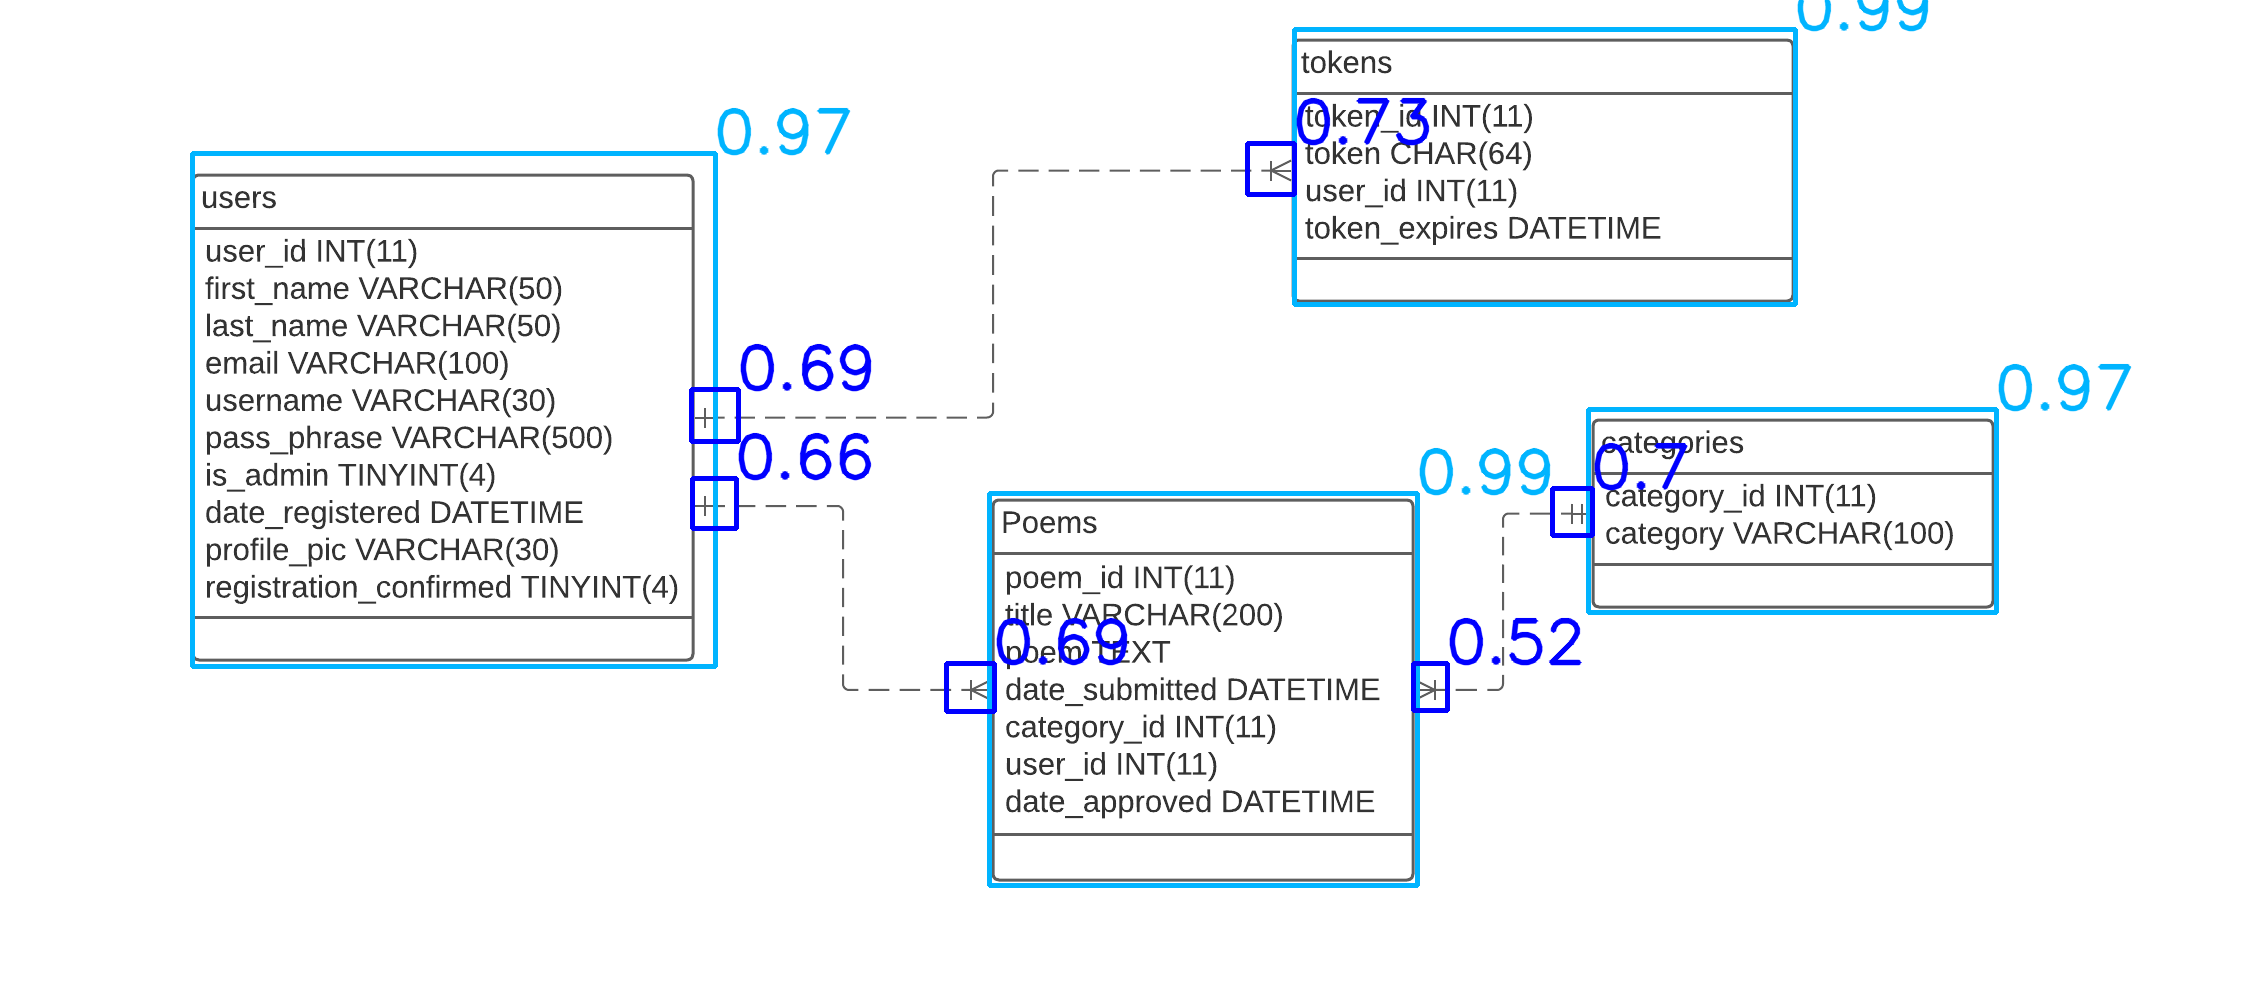

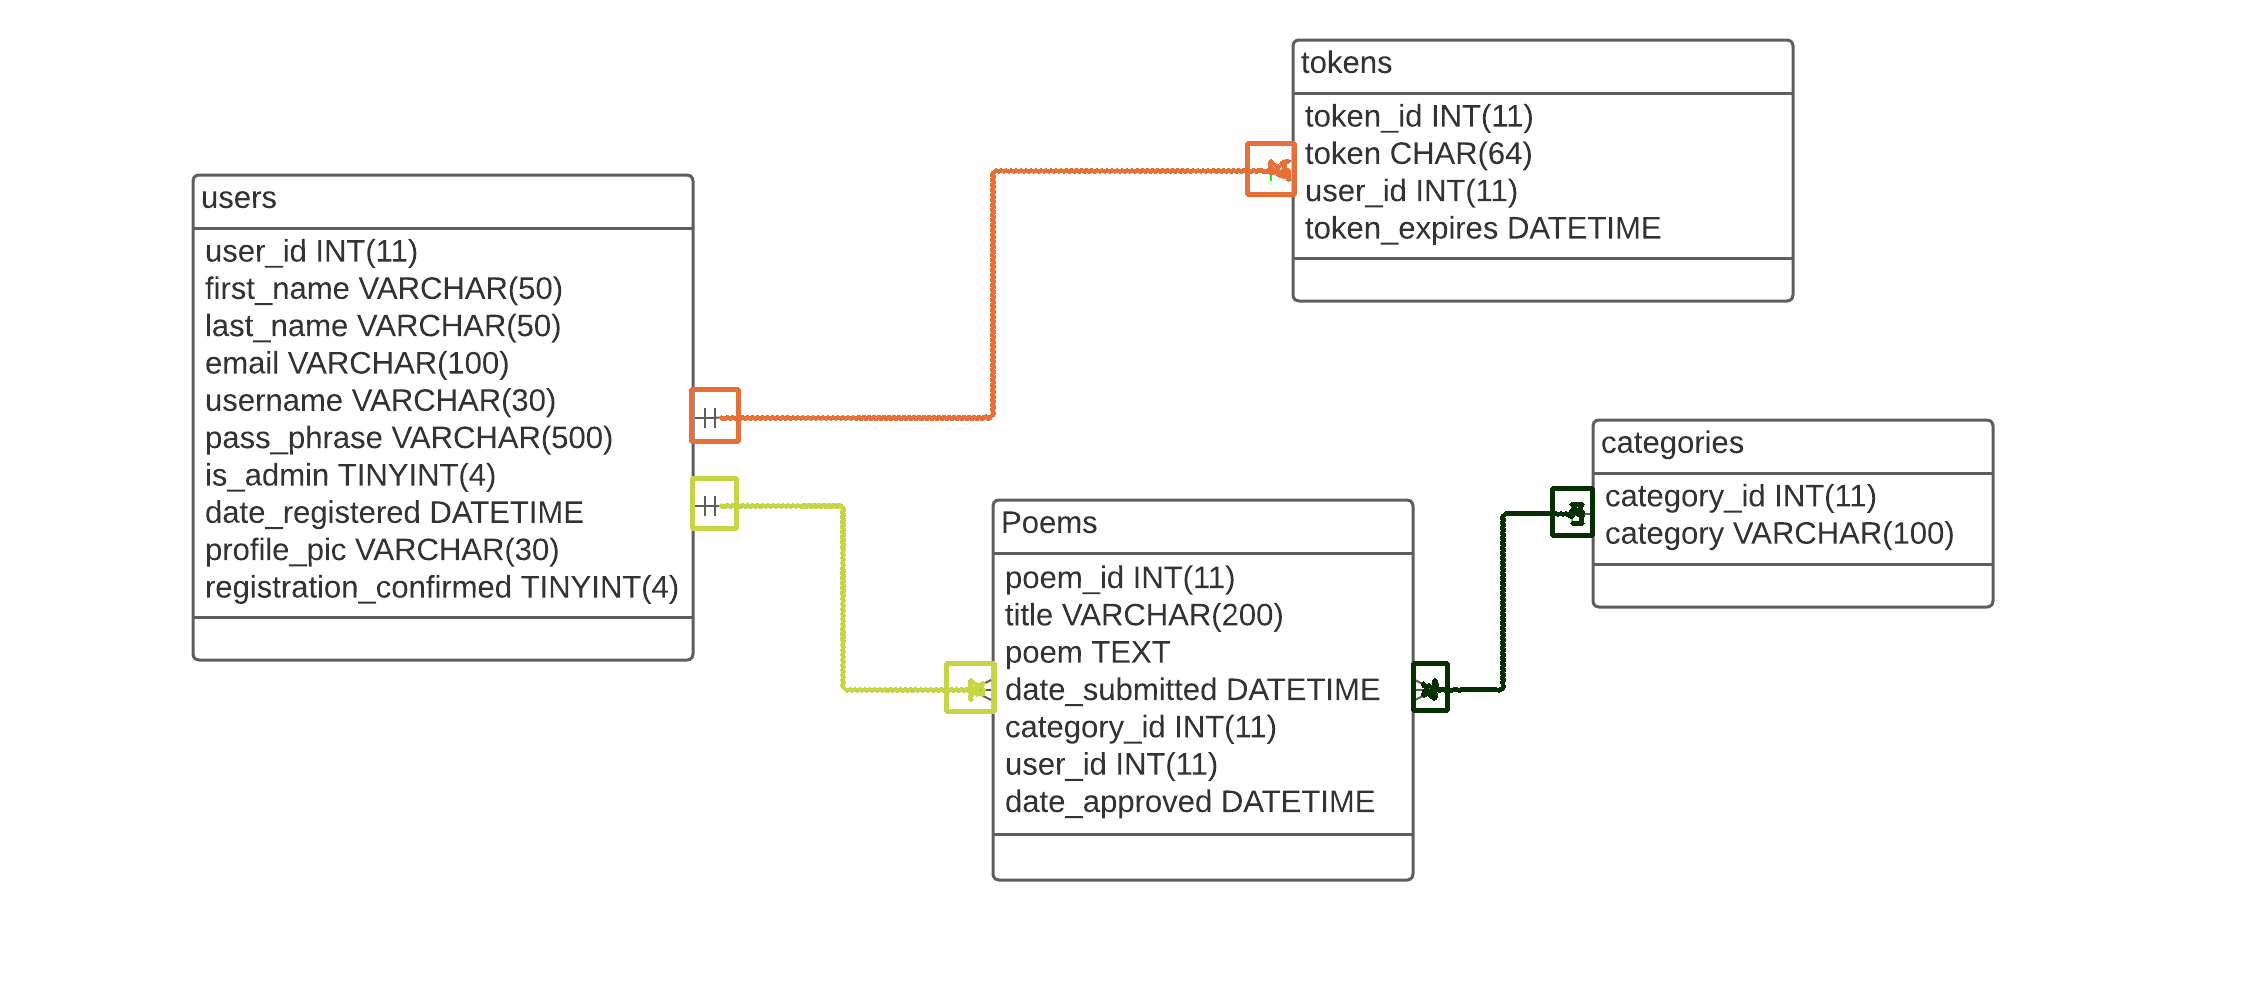

In [21]:
img_path = "/home/nacho/TFI-Cazcarra/data/images_testing/demostracion_lucid.png"
# img_path = "/home/nacho/TFI-Cazcarra/data/imagenes_extra/ejemplo_diagrama.png"

img = Image.open(img_path).convert("RGB")
img_tensor = transform(img)

tablas_pred = model_tablas([img_tensor])[1][0]
tablas_boxes, tablas_scores = filter_predictions(tablas_pred, nms_threshold=0.5, score_threshold=0.5)
cardinalidades_pred = predict_tiles(img, model=model_cardinalidades, is_yolo=True, transform=transform)
cardinalidades_boxes, cardinalidades_scores = filter_predictions(cardinalidades_pred, nms_threshold=0.5, 
                                                             score_threshold=0.5)

img2 = visualize_boxes(img, tablas_boxes, color=(0,180,255), thickness=3, scores=tablas_scores.tolist())
display(visualize_boxes(img2, cardinalidades_boxes, color=(0,0,255), thickness=3, 
                        scores=cardinalidades_scores.tolist()))

conexiones = get_pairs(tablas_boxes, cardinalidades_boxes, img=img, plot=True)

In [ ]:
ocr = get_ocr_model()

In [ ]:
def draw_bbox_ocr(img, xmin, ymin, xmax, ymax, color):
    isClosed = True
    thickness = 2
    pts = np.array([xmin, ymin, xmax, ymax])
    return cv2.polylines(img, [pts], isClosed, color, thickness)

def visualize_boxes_ocr(img, boxes, color=(0, 255, 0)):
    img = np.array(img)
    for b in boxes:
        xmin = b[0].astype(int).tolist()
        ymin = b[1].astype(int).tolist()
        xmax = b[2].astype(int).tolist()
        ymax = b[3].astype(int).tolist()
        img = draw_bbox_ocr(img, xmin, ymin, xmax, ymax, color)
    return Image.fromarray(img)

def images_together(images, titles=[]):
    rcParams["figure.figsize"] = (10,6)
    
    fig, ax = plt.subplots(1,len(images))
    for i in range(len(images)):
        ax[i].imshow(images[i])
        if titles:
            ax[i].set_title(titles[i])
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    plt.show()

In [ ]:
img_arr = np.array(img)
plots = []


for t in tablas_boxes:
    t = t.detach().numpy().astype(int).tolist()
    tabla_cropped = img_arr[t[1]:t[3], t[0]:t[2]]
    if len(tabla_cropped.shape) == 3 and tabla_cropped.shape[-1] > 3:
        tabla_cropped = tabla_cropped[:,:,:3]
    boxes_default, _ = ocr.text_detector(tabla_cropped)
    plotted = visualize_boxes_ocr(tabla_cropped, boxes_default, color=(0, 0, 255))
    plots.append(plotted)

%matplotlib inline
display(images_together(plots,titles=[]))

In [ ]:
tablas_boxes = tablas_boxes.detach().numpy().astype(int)
all_tables, tables_names = predict_ocr(img=img, tablas=tablas_boxes, ocr_model=ocr, scale_percent=100)

In [ ]:
from pprint import pprint

pprint(all_tables)

In [ ]:
code = generate_db(conexiones, all_tables, tables_names, lang="en")
print(code)